# Population Weighting Demonstration

This notebook demonstrates how to implement population weighting in the service coverage variance objective. We will compare the effects of different population weighting schemes on the variance of service coverage across zones.


## Data Preparation and Problem Setup

In [ ]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd

# Add src to path
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
src_path = os.path.join(project_root, "src")
if src_path not in sys.path:
    sys.path.insert(0, src_path)

print("=== TRANSIT OPTIMIZATION SETUP ===")
print("🚀 Starting self-contained optimization workflow")
print("📊 This notebook will prepare data from scratch and run PSO optimization")


=== TRANSIT OPTIMIZATION SETUP ===
🚀 Starting self-contained optimization workflow
📊 This notebook will prepare data from scratch and run PSO optimization


### GTFS Data Loading

First, we'll load the GTFS feed and transform it into optimization data structure.
This replicates the key steps from notebook 1 but focuses only on what's needed for optimization.


In [2]:
from transit_opt.preprocessing.prepare_gtfs import GTFSDataPreparator

print("=== LOADING GTFS DATA ===")

# Create GTFS preparator with same settings as notebook 1
preparator = GTFSDataPreparator(
    gtfs_path='../data/external/study_area_gtfs_bus.zip',
    interval_hours=6,  # 4 periods per day
    date=None,  # Use full GTFS feed
    turnaround_buffer=1.15,  # 15% buffer
    max_round_trip_minutes=240.0,  # Maximum round-trip time
    no_service_threshold_minutes=480.0,  # Threshold for no-service mapping
    log_level="INFO"  # Less verbose than notebook 1
)

# Define allowed headways for optimization
allowed_headways = [10, 15, 30, 60, 120, 240] # in minutes

print(f"📋 Allowed headways: {allowed_headways} minutes")
print("🔄 Extracting optimization data...")

# Extract optimization data structure
opt_data = preparator.extract_optimization_data(allowed_headways)

print(f"\n✅ GTFS DATA PROCESSED:")
print(f"   📊 Routes: {opt_data['n_routes']}")
print(f"   ⏰ Time intervals: {opt_data['n_intervals']} (3h each)")
print(f"   🎯 Decision variables: {opt_data['decision_matrix_shape'][0]} × {opt_data['decision_matrix_shape'][1]} = {np.prod(opt_data['decision_matrix_shape'])}")
print(f"   🚗 Current peak fleet: {opt_data['constraints']['fleet_analysis']['total_current_fleet_peak']} vehicles")
print(f"   🔢 Headway choices: {opt_data['n_choices']} (including no-service)")


2025-10-06 16:52:35,547 - transit_opt.preprocessing.prepare_gtfs - INFO - Initializing GTFSDataPreparator with 6h intervals
2025-10-06 16:52:35,548 - transit_opt.preprocessing.prepare_gtfs - INFO - Loading GTFS feed from ../data/external/study_area_gtfs_bus.zip


=== LOADING GTFS DATA ===


2025-10-06 16:52:37,982 - transit_opt.preprocessing.prepare_gtfs - INFO - Using full GTFS feed (all service periods)
2025-10-06 16:52:39,369 - transit_opt.preprocessing.prepare_gtfs - INFO - GTFS loaded and cached in 3.82 seconds
2025-10-06 16:52:39,369 - transit_opt.preprocessing.prepare_gtfs - INFO - Dataset: 13,974 trips, 703,721 stop times
2025-10-06 16:52:39,370 - transit_opt.preprocessing.prepare_gtfs - INFO - Extracting optimization data with 6 allowed headways
2025-10-06 16:52:39,370 - transit_opt.preprocessing.prepare_gtfs - INFO - Extracting route essentials with 6-hour intervals


📋 Allowed headways: [10, 15, 30, 60, 120, 240] minutes
🔄 Extracting optimization data...


2025-10-06 16:52:40,369 - transit_opt.preprocessing.prepare_gtfs - WARNING - Route 73302: Round-trip 317.4min exceeds limit (240.0min), filtered out
2025-10-06 16:52:40,418 - transit_opt.preprocessing.prepare_gtfs - WARNING - Route 54721: Round-trip 366.8min exceeds limit (240.0min), filtered out
2025-10-06 16:52:41,730 - transit_opt.preprocessing.prepare_gtfs - WARNING - Route 30922: Round-trip 247.2min exceeds limit (240.0min), filtered out
2025-10-06 16:52:42,338 - transit_opt.preprocessing.prepare_gtfs - WARNING - Route 12490: Round-trip 416.3min exceeds limit (240.0min), filtered out
2025-10-06 16:52:42,395 - transit_opt.preprocessing.prepare_gtfs - WARNING - Route 37599: Round-trip 355.3min exceeds limit (240.0min), filtered out
2025-10-06 16:52:44,349 - transit_opt.preprocessing.prepare_gtfs - WARNING - Route 59129: Round-trip 396.7min exceeds limit (240.0min), filtered out
2025-10-06 16:52:47,067 - transit_opt.preprocessing.prepare_gtfs - WARNING - Route 73828: Round-trip 258.8


✅ GTFS DATA PROCESSED:
   📊 Routes: 147
   ⏰ Time intervals: 4 (3h each)
   🎯 Decision variables: 147 × 4 = 588
   🚗 Current peak fleet: 1250 vehicles
   🔢 Headway choices: 7 (including no-service)


### Spatial Boundary Setup

Load the study area boundary for spatial filtering and analysis.
This ensures optimization focuses on the relevant geographic area.


In [3]:
from transit_opt.optimisation.spatial.boundaries import StudyAreaBoundary

print("\n=== SPATIAL BOUNDARY SETUP ===")

# Load boundary geometry
boundary_gdf = gpd.read_file("../data/external/boundaries/study_area_boundary.geojson")
print(f"📍 Loaded boundary with {len(boundary_gdf)} feature(s)")

# Create study area boundary with buffer
study_boundary = StudyAreaBoundary(
    boundary_gdf=boundary_gdf,
    crs="EPSG:3857",  # Web Mercator for spatial analysis
    buffer_km=2.0     # 2km buffer around boundary
)

print(f"✅ Study area boundary created:")
print(f"   📐 CRS: {study_boundary.target_crs}")
print(f"   📏 Buffer: 2km")


=== SPATIAL BOUNDARY SETUP ===
📍 Loaded boundary with 2607 feature(s)
✅ Validated metric CRS: EPSG:3857
🔄 Converting boundary CRS: EPSG:4326 → EPSG:3857
📏 Applied 2.0km buffer
✅ Study area set: 1 polygon(s) in EPSG:3857
✅ Study area boundary created:
   📐 CRS: EPSG:3857
   📏 Buffer: 2km


### Load Population Data

We use WorldPop data for population weighting. You can find national datasets at https://www.worldpop.org/

There are two options:
1. 1km resolution data
2. 100m resolution data

I am using the 1km raster layer. The 100m layer has a lot of 0 and negative values, so it is worth understanding this better before using it.


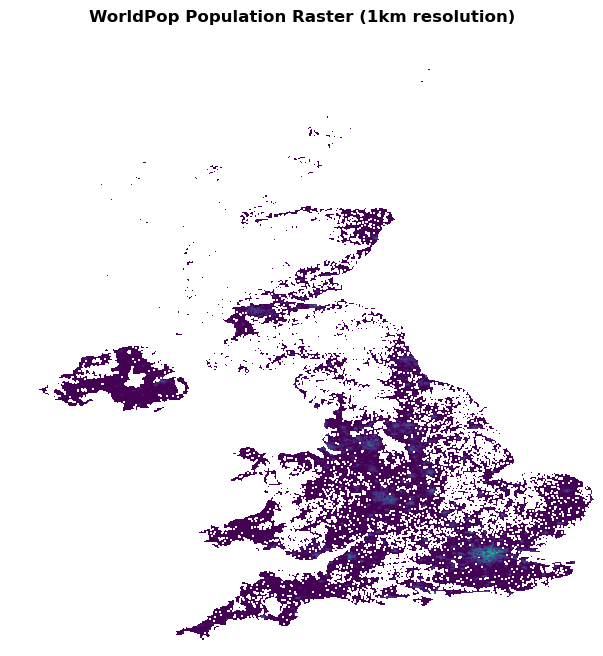

In [4]:
# Plot the raster layer
worldpop_path = "../data/external/population/gbr_pop_2025_CN_1km_R2025A_UA_v1.tif"

# Plot a very simple map of the raster layer on its own
import rasterio
from rasterio.plot import show

with rasterio.open(worldpop_path) as src:
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    show(src, ax=ax, title="WorldPop Population Raster (1km resolution)")
    ax.set_axis_off()
    plt.show()

## Calculating variance using different approaches

Here i show how to use the HexagonalCoverageObjective with different population weighting schemes. We can calculate variance in different ways:

- Standard (no weighting)
- Spatial lag: Use neighboring zones vehicle counts to smooth out variations
- Population weighted (linear)
- Population weighted (power): Apply a power transformation to population data to adjust weighting sensitivity. Values >1 amplify differences, values <1 reduce them. 

In [ ]:
from transit_opt.optimisation.objectives.service_coverage import HexagonalCoverageObjective

# === POPULATION WEIGHTING DEMO ===
print("\n=== POPULATION WEIGHTING COMPARISON ===")

worldpop_path = "../data/external/population/gbr_pop_2025_CN_1km_R2025A_UA_v1.tif"


# Create 4 different objective configurations
objectives = {
    "Standard": HexagonalCoverageObjective(
        optimization_data=opt_data,
        spatial_resolution_km=3.0,
        crs="EPSG:3857",
        boundary=study_boundary,
        spatial_lag=False,
        population_weighted=False
    ),
    "Spatial Lag": HexagonalCoverageObjective(
        optimization_data=opt_data,
        spatial_resolution_km=3.0,
        crs="EPSG:3857",
        boundary=study_boundary,
        spatial_lag=True,
        alpha=0.2,
        population_weighted=False
    ),
    "Population Weighted": HexagonalCoverageObjective(
        optimization_data=opt_data,
        spatial_resolution_km=3.0,
        crs="EPSG:3857",
        boundary=study_boundary,
        spatial_lag=False,
        population_weighted=True,
        population_layer=worldpop_path
    ),
    "Population + Spatial": HexagonalCoverageObjective(
        optimization_data=opt_data,
        spatial_resolution_km=3.0,
        crs="EPSG:3857",
        boundary=study_boundary,
        spatial_lag=True,
        alpha=0.2,
        population_weighted=True,
        population_layer=worldpop_path
    ),
    "Population + Spatial + Power": HexagonalCoverageObjective(
        optimization_data=opt_data,
        spatial_resolution_km=3.0,
        crs="EPSG:3857",
        boundary=study_boundary,
        spatial_lag=True,
        alpha=0.2,
        population_weighted=True,
        population_layer=worldpop_path,
        population_power=0.2  # Square root weighting
    ),

}

# Evaluate initial solution with all methods
print("\n📊 VARIANCE COMPARISON (Initial Solution):")
print("-" * 50)
results = {}

for name, obj in objectives.items():
    variance = obj.evaluate(opt_data['initial_solution'])
    results[name] = variance
    print(f"{name:20}: {variance:.4f}")

# Show variance value and relative differences
print("\n📊 VARIANCE COMPARISON SUMMARY:")
print("-" * 50)
baseline = results["Standard"]
for name, variance in results.items():
    if name != "Standard":
        pct_change = ((variance - baseline) / baseline) * 100
        print(f"{name:20}: Variance={variance:.4f}. Compared to Standard: ({pct_change:+.1f}%)")



=== POPULATION WEIGHTING COMPARISON ===
🗺️ Setting up spatial analysis with 3.0km resolution
🗺️  Reprojected 6897 stops to EPSG:3857
🎯 Applying boundary filter to 6897 stops...
🔍 Filtered 6897 → 4405 points
✅ Filtered to 4405 stops within boundary
🔧 Creating 18 × 18 = 324 grid cells
   Grid bounds: (-195846, 7111259) to (-142157, 7162476) meters
   Cell size: 3000.0m × 3000.0m
✅ Created 324 hexagonal zones in EPSG:3857
🎯 Applying boundary filter to 324 grid cells...
🔍 Filtered 324 → 251 grid cells
✅ Filtered to 251 grid cells within boundary
🚀 Using spatial join for zone mapping...
✅ Mapped 4405 stops to zones
🚀 Pre-computing route-stop mappings...
✅ Cached stops for 187 routes
✅ Spatial system ready: 251 hexagonal zones
🗺️ Setting up spatial analysis with 3.0km resolution
🗺️  Reprojected 6897 stops to EPSG:3857
🎯 Applying boundary filter to 6897 stops...
🔍 Filtered 6897 → 4405 points
✅ Filtered to 4405 stops within boundary
🔧 Creating 18 × 18 = 324 grid cells
   Grid bounds: (-195846

### Visualise the population data used for weighting (zoomed in on boundary area)

```python


=== POPULATION INTERPOLATION VISUALIZATION ===


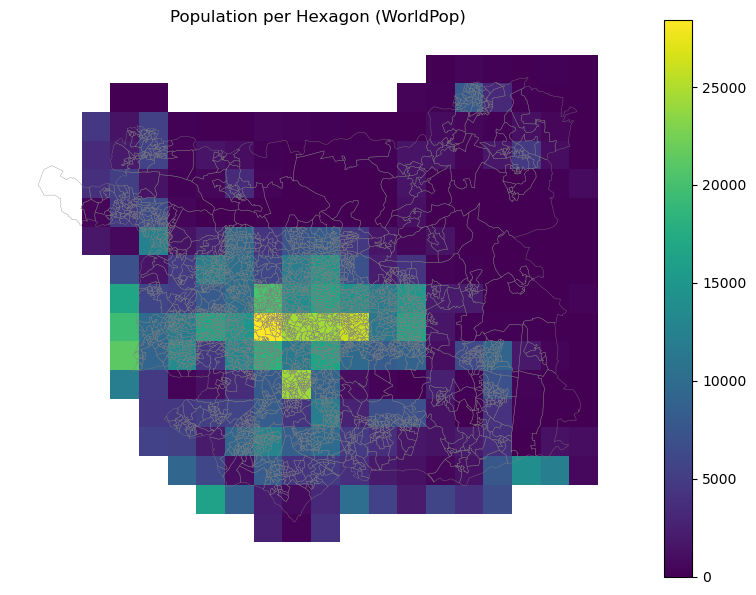


📊 Population Statistics:
   Total hexagons: 251
   Total population: 1,089,983
   Hexagons with population: 230
   Mean population per hex: 4342.6
   Max population per hex: 28,402


In [6]:
# === VISUALIZE POPULATION INTERPOLATION ===
print("\n=== POPULATION INTERPOLATION VISUALIZATION ===")

# Get population-weighted objective
pop_obj = objectives["Population Weighted"]
hexgrid_gdf = pop_obj.spatial_system.hex_grid.copy()
hex_pop = pop_obj.population_per_zone

# Add population to hexgrid for visualization
hexgrid_gdf['population'] = hex_pop

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

# Plot 2: Hexgrid with population
hexgrid_gdf.plot(column='population', cmap='viridis', k = 100, legend=True, ax=ax)
boundary_gdf.to_crs(hexgrid_gdf.crs).plot(color='none', edgecolor='grey', linewidth=0.3, alpha=0.8, ax=ax)

ax.set_title("Population per Hexagon (WorldPop)")
ax.set_axis_off()

plt.tight_layout()
plt.show()

# Population statistics
print(f"\n📊 Population Statistics:")
print(f"   Total hexagons: {len(hex_pop)}")
print(f"   Total population: {np.sum(hex_pop):,.0f}")
print(f"   Hexagons with population: {np.sum(hex_pop > 0)}")
print(f"   Mean population per hex: {np.mean(hex_pop):.1f}")
print(f"   Max population per hex: {np.max(hex_pop):,.0f}")